In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from IPython.display import Audio
from typing import Tuple
import librosa

%matplotlib notebook

from scipy.ndimage.filters import maximum_filter
from scipy.ndimage.morphology import generate_binary_structure, binary_erosion
from scipy.ndimage.morphology import iterate_structure
from typing import Tuple, Callable, List

In [2]:
def from_mp3(local_song_path: str, sr: int):
    """mp3 or other audio file to .npy"""
    samples, sample_rate = librosa.load(local_song_path, sr=sr, mono=True)#, offset=90, duration=60)

    print(local_song_path+" loaded!")
    return samples

In [5]:
sampling_rate = 44100
bowie = from_mp3("./MusicMP3s/"+"David Bowie - Space Oddity"+".mp3",sampling_rate)
samples = bowie

TypeError: from_mp3() got an unexpected keyword argument 'duration'

In [3]:
from microphone import record_audio

listen_time = 12  # seconds
frames, sampling_rate = record_audio(listen_time)

samples = np.hstack([np.frombuffer(i, np.int16) for i in frames])

Using input device 'Microphone Array (Intel® Smart'
Recording ended


In [4]:
# Listen to your recording 
Audio(samples, rate=sampling_rate)

In [5]:
recorded_audio = samples

<IPython.core.display.Javascript object>


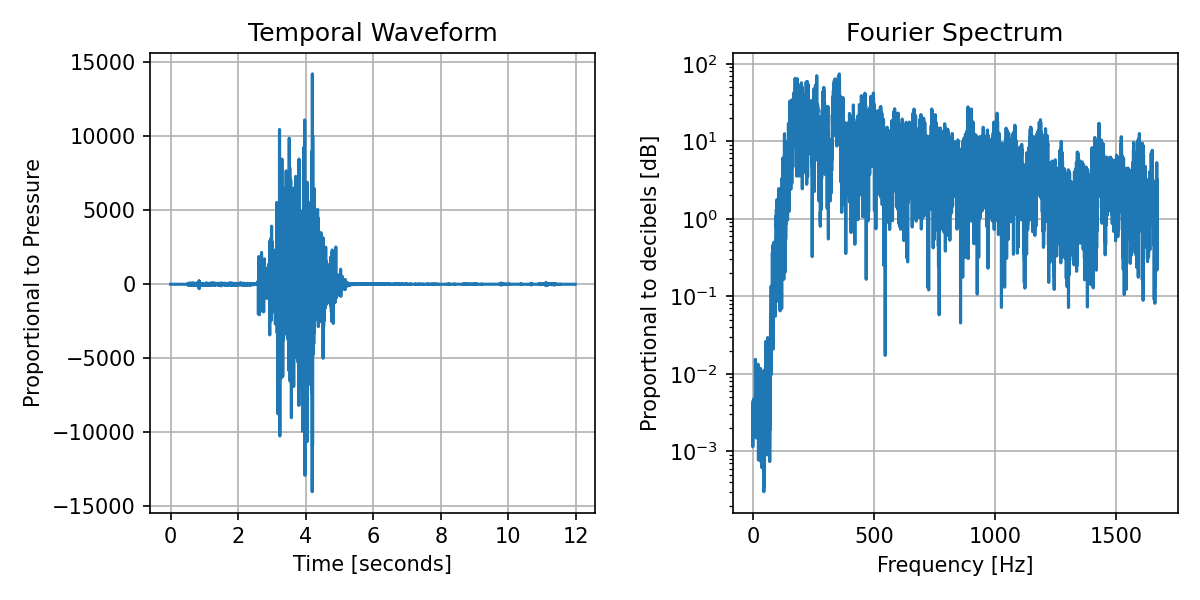

In [6]:
fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(8, 4))

# Compute the times at which each sample was recorded in seconds

# Define the following variable(s)
# `time`: array storing t_0, t_1, ..., t_{N-1} 
time = np.arange(len(recorded_audio)) / sampling_rate  # <COGLINE>

# Plotting the waveform (every 100th datapoint for sake of efficiency)
ax0.plot(time[::100], recorded_audio[::100])  
ax0.set_xlabel("Time [seconds]")
ax0.set_ylabel("Proportional to Pressure")
ax0.set_title("Temporal Waveform")
ax0.grid(True)


# Plotting the Fourier spectrum

# Compute the real-valued Fourier coefficents for this recording
# and the corresponding frequencies (in Hz)

# Define the following variable(s)
# `ak`: array storing the real-valued Fourier coeffs: a_0, a_1, ..., a_{N//2}
# `fk`: array storing the associated frequencies: 0/T, 1/T, ..., (N//2)/T

N = len(recorded_audio)
T = N / sampling_rate  # total time-span of audio clip

# FFT: yn -> ck   (complex-valued Fourier coefficients)
ck = np.fft.rfft(recorded_audio)


# convert ck (complex Fourier coeff) -> |ak| (real-valued coeff)
ak = np.abs(ck) / N
ak[1:(-1 if N%2 == 0 else None)]*=2


# convert k = 0, 1, ... to freq = 0, 1/T, 2/T, ..., (int(N/2) + 1)/T
fk = np.arange(len(ak)) / T



ax1.plot(fk[:20000], ak[:20000])
ax1.set_title("Fourier Spectrum")
ax1.set_xlabel("Frequency [Hz]")
ax1.set_ylabel("Proportional to decibels [dB]")
ax1.grid(True)
ax1.set_yscale("log") # using a log scale
fig.tight_layout()

<IPython.core.display.Javascript object>


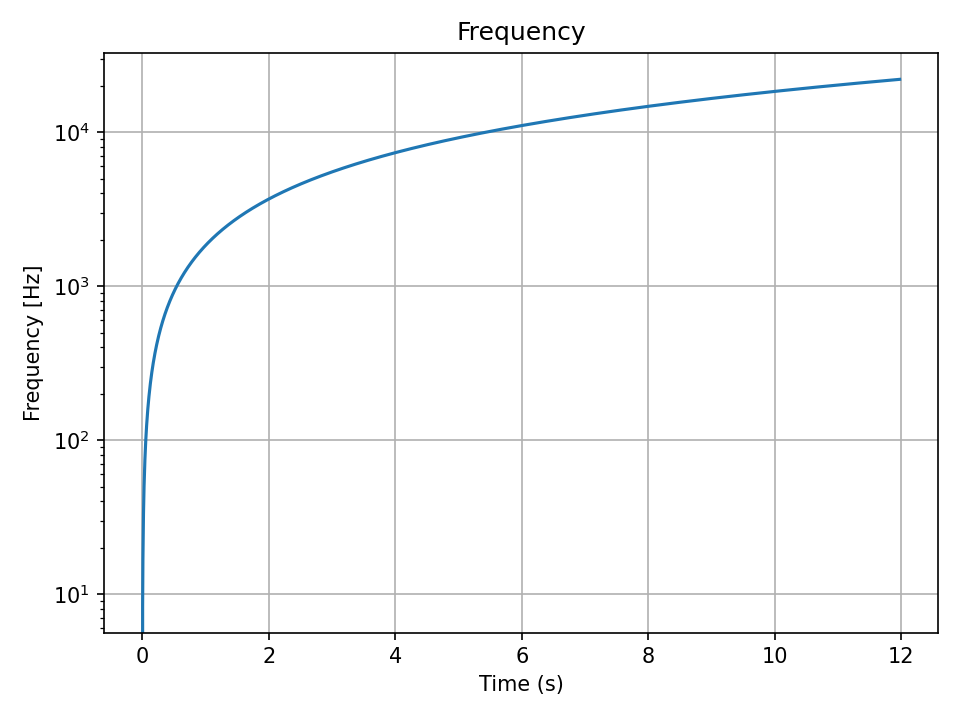

In [7]:
fig, ax = plt.subplots()

ax.plot(time[::200], fk[::100])#, ak[:20000])
ax.set_title("Frequency")
ax.set_xlabel("Time (s)")
ax.set_ylabel("Frequency [Hz]")
ax.grid(True)
ax.set_yscale("log") # using a log scale
fig.tight_layout()

<IPython.core.display.Javascript object>


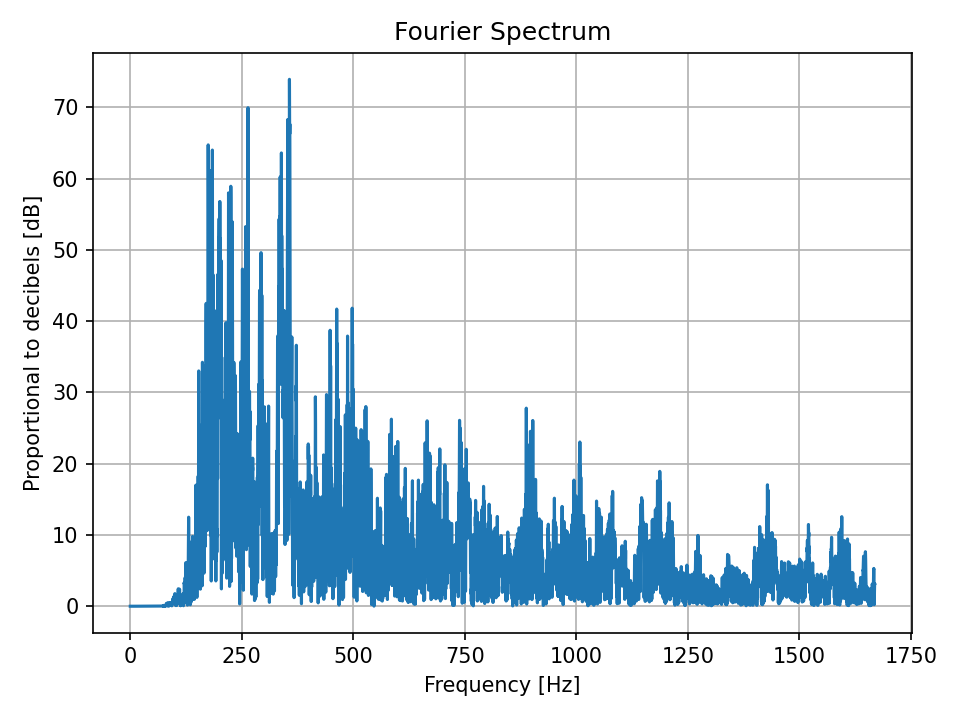

In [8]:
fig, ax1 = plt.subplots()
ax1.plot(fk[:20000], ak[:20000])
ax1.set_title("Fourier Spectrum")
ax1.set_xlabel("Frequency [Hz]")
ax1.set_ylabel("Proportional to decibels [dB]")
ax1.grid(True)
#ax1.set_yscale("log")
fig.tight_layout()

#comenting out the log scale we get the normal fourier graph

<IPython.core.display.Javascript object>


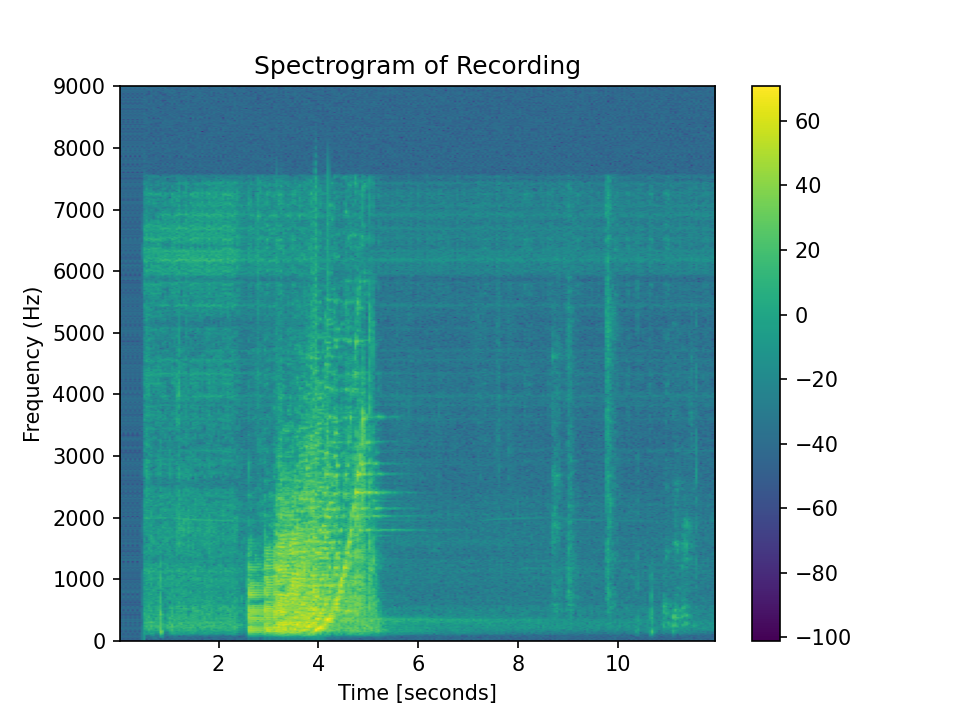

In [9]:
# using matplotlib's built-in spectrogram function
import matplotlib.mlab as mlab

fig, ax = plt.subplots()

S, freqs, times, im = ax.specgram(
    recorded_audio,
    NFFT=4096,
    Fs=sampling_rate,
    window=mlab.window_hanning,
    noverlap=4096 // 2,
    mode='magnitude',
    scale="dB"
)
fig.colorbar(im)

ax.set_xlabel("Time [seconds]")
ax.set_ylabel("Frequency (Hz)")
ax.set_title("Spectrogram of Recording")
ax.set_ylim(0, 9000);

In [10]:
S, freqs, times = mlab.specgram(
    samples,
    NFFT=4096,
    Fs=sampling_rate,
    window=mlab.window_hanning,
    noverlap=int(4096 / 2),
    mode='magnitude'
)

In [11]:
def nth_max(arr, n):
    copy = np.copy(arr)
    sorted_arr = np.sort(copy.flatten())
    return sorted_arr[-n]

In [12]:
def find_freqs(S: np.ndarray, freqs: np.ndarray, times: np.ndarray, interval: int, n:int):
    ## iterate through times
    freqs_total = []
    final_times = []
    max_len_f = 0
    cutoff = nth_max(S, n)
    for i in range(0, len(times), interval):
        freqs_tn=[]
        for j in range(0, len(S[:,i])):
            if S[j,i] >= cutoff and freqs[j] >= 20 and freqs[j] <= 9000:
                freqs_tn.append(freqs[j])
                
        if len(freqs_tn) > 0:
            freqs_total.append(freqs_tn)
            final_times.append(times[i])
            if len(freqs_tn) > max_len_f:
                max_len_f = len(freqs_tn)
            
        
    return freqs_total, final_times, max_len_f


In [13]:
n = 10 * len(times)
fs, ts, max_len_f = find_freqs(S, freqs, times, 1, n)
print(fs[0])

[139.9658203125, 150.732421875, 161.4990234375, 172.265625, 183.0322265625, 193.798828125, 204.5654296875, 215.33203125, 226.0986328125, 236.865234375, 344.53125, 355.2978515625, 366.064453125, 376.8310546875, 387.59765625, 398.3642578125, 409.130859375, 419.8974609375, 430.6640625, 441.4306640625, 462.9638671875, 473.73046875, 484.4970703125, 495.263671875, 506.0302734375, 516.796875, 527.5634765625, 538.330078125, 710.595703125, 732.12890625, 742.8955078125, 753.662109375, 764.4287109375, 775.1953125, 785.9619140625, 796.728515625, 807.4951171875, 818.26171875]


In [14]:
def sound_to_light(freq):
    """Takes in frequency of sound in Hz and returns wavelength of light in nm"""
    sound_min = 20 # Hz
    sound_max = 9000 # Hz
    light_wavelength1 = 380 * 10**(-9) # m
    light_wavelength2 = 740 * 10**(-9) # m
    c = 299792458 # m/s
    light_min_freq = c / light_wavelength2 # Hz
    light_max_freq = c / light_wavelength1 # Hz
    
    light_range = light_max_freq - light_min_freq # Hz
    sound_range = sound_max - sound_min # Hz
    
    sound_shifted = freq - sound_min # Hz
    light_shifted = sound_shifted * light_range / sound_range # Hz
    light_freq = light_shifted + light_min_freq # Hz
    wavlen_m = c / light_freq #m
    wavlen_nm = wavlen_m * 10**9 #nm
    
    return wavlen_nm

In [15]:
#!/usr/bin/env python
# vim:set ft=python fileencoding=utf-8 sr et ts=4 sw=4 : See help 'modeline'

'''
    == A few notes about color ==

    Color   Wavelength(nm) Frequency(THz)
    Red     620-750        484-400
    Orange  590-620        508-484
    Yellow  570-590        526-508
    Green   495-570        606-526
    Blue    450-495        668-606
    Violet  380-450        789-668

    f is frequency (cycles per second)
    l (lambda) is wavelength (meters per cycle)
    e is energy (Joules)
    h (Plank's constant) = 6.6260695729 x 10^-34 Joule*seconds
                         = 6.6260695729 x 10^-34 m^2*kg/seconds
    c = 299792458 meters per second
    f = c/l
    l = c/f
    e = h*f
    e = c*h/l

    List of peak frequency responses for each type of 
    photoreceptor cell in the human eye:
        S cone: 437 nm
        M cone: 533 nm
        L cone: 564 nm
        rod:    550 nm in bright daylight, 498 nm when dark adapted. 
                Rods adapt to low light conditions by becoming more sensitive.
                Peak frequency response shifts to 498 nm.

'''


def wavelength_to_rgb(wavelength, gamma=0.8):

    '''This converts a given wavelength of light to an 
    approximate RGB color value. The wavelength must be given
    in nanometers in the range from 380 nm through 750 nm
    (789 THz through 400 THz).

    Based on code by Dan Bruton
    http://www.physics.sfasu.edu/astro/color/spectra.html
    '''

    wavelength = float(wavelength)
    if wavelength >= 380 and wavelength <= 440:
        attenuation = 0.3 + 0.7 * (wavelength - 380) / (440 - 380)
        R = ((-(wavelength - 440) / (440 - 380)) * attenuation) ** gamma
        G = 0.0
        B = (1.0 * attenuation) ** gamma
    elif wavelength >= 440 and wavelength <= 490:
        R = 0.0
        G = ((wavelength - 440) / (490 - 440)) ** gamma
        B = 1.0
    elif wavelength >= 490 and wavelength <= 510:
        R = 0.0
        G = 1.0
        B = (-(wavelength - 510) / (510 - 490)) ** gamma
    elif wavelength >= 510 and wavelength <= 580:
        R = ((wavelength - 510) / (580 - 510)) ** gamma
        G = 1.0
        B = 0.0
    elif wavelength >= 580 and wavelength <= 645:
        R = 1.0
        G = (-(wavelength - 645) / (645 - 580)) ** gamma
        B = 0.0
    elif wavelength >= 645 and wavelength <= 750:
        attenuation = 0.3 + 0.7 * (750 - wavelength) / (750 - 645)
        R = (1.0 * attenuation) ** gamma
        G = 0.0
        B = 0.0
    else:
        R = 0.0
        G = 0.0
        B = 0.0
    R *= 255
    G *= 255
    B *= 255
    return (int(R), int(G), int(B))

In [16]:
def sound_arr_to_light_arr(freqs):
    rgbs = [[wavelength_to_rgb(sound_to_light(f)) for f in fns] for fns in freqs]
    return rgbs

In [17]:
rgbs = sound_arr_to_light_arr(fs)
print(rgbs[0])

[(129, 0, 0), (130, 0, 0), (132, 0, 0), (133, 0, 0), (134, 0, 0), (135, 0, 0), (137, 0, 0), (138, 0, 0), (139, 0, 0), (141, 0, 0), (153, 0, 0), (154, 0, 0), (155, 0, 0), (157, 0, 0), (158, 0, 0), (159, 0, 0), (160, 0, 0), (161, 0, 0), (162, 0, 0), (164, 0, 0), (166, 0, 0), (167, 0, 0), (168, 0, 0), (169, 0, 0), (171, 0, 0), (172, 0, 0), (173, 0, 0), (174, 0, 0), (192, 0, 0), (194, 0, 0), (195, 0, 0), (196, 0, 0), (197, 0, 0), (198, 0, 0), (199, 0, 0), (200, 0, 0), (201, 0, 0), (202, 0, 0)]


<IPython.core.display.Javascript object>


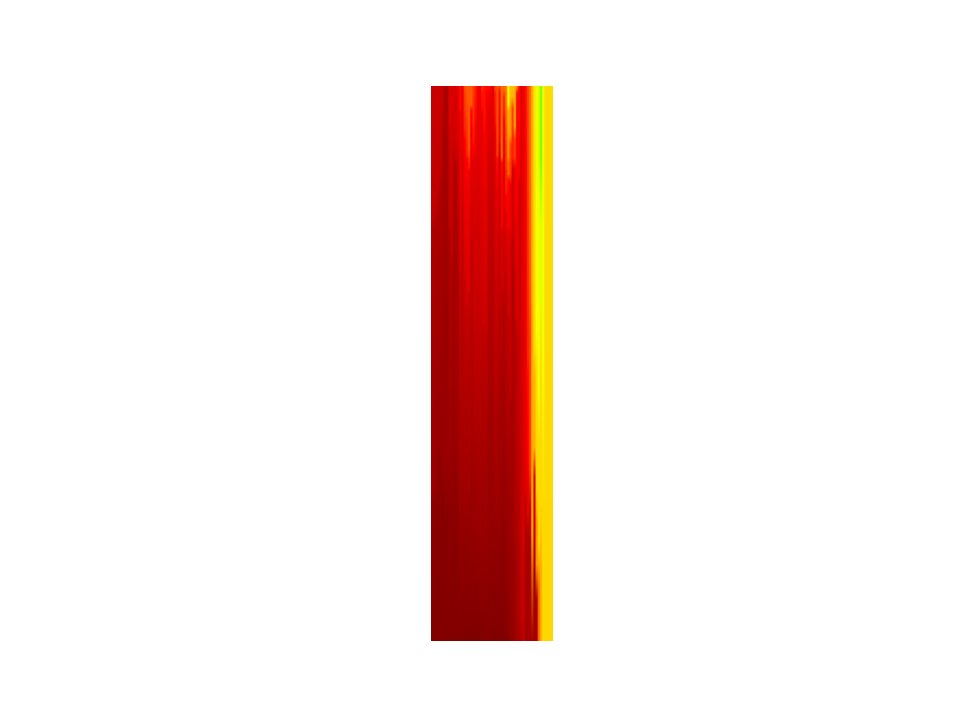

red
green
blue


In [18]:

fig, ax = plt.subplots()


arrwidth = len(times)
if max_len_f > 256:
    arrheight = max_len_f
else:
    arrheight = 256


## for each time, get colors
## divide graph by number of colors to display different colors
def get_arr(color):
    """makes an array values of one color value (0 for r, 1 for g, and 2 for b) itterating y then x to make an array to be graphed"""
    prev_x = 0
    prev_colors = np.zeros(arrheight)
    final_arr = np.ndarray(0)
    for i in range(0, len(ts)):
        x = np.where(times == ts[i])[0].item()
        for j in range(1, len(rgbs[i])):
            if j == 1:
                colors = np.linspace(rgbs[i][j-1][color], rgbs[i][j][color], int(np.round(arrheight/(len(rgbs[i])-1))), dtype=int)#int(np.round(height_f/len(rgbs[i]))))
            else:
                colors = np.hstack((colors, np.linspace(rgbs[i][j-1][color], rgbs[i][j][color], int(np.round(arrheight/(len(rgbs[i])-1))), dtype=int)))#int(np.round(height_f/len(rgbs[i]))))))
        
        colors = colors[0:arrheight] # in case, due to rounding error, colors is longer than arrheight
        if len(colors) == 0: # if there are no colors at this frequency
            colors = np.zeros(arrheight)
        while len(colors) < arrheight: # in case, due to rounding error, colors is shorter than arrheight --> use end color to fill in extra space
            colors = np.hstack((colors, colors[-1]))
                
        if i != 0:
            final_arr = np.vstack((final_arr, np.linspace(prev_colors, colors, x-prev_x, dtype=int)))
        else:
            final_arr = colors # no gradient needed for the first row
        prev_x = x
        prev_colors = colors
    
    return final_arr.T[:,:,None]


## 
r = get_arr(0)
print("red")
g = get_arr(1)
print("green")
b = get_arr(2)
print("blue")

img = np.concatenate([r, g, b], axis=2)

plt.imshow(img, origin="lower")
plt.axis("off")

plt.show()

In [272]:
Audio(samples, rate=sampling_rate)